### Support Vector Machine - Car Dataset
Joshua Rosell

Importing needed libraries.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsOneClassifier

Reading the dataset and adding column names.

In [2]:
df = pd.read_csv('car_data.csv', header=None)
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

Checking a few rows and the new column names.

In [3]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Checking if rows are complete.

In [4]:
df.shape

(1728, 7)

Counting frequencies for the variables to see if there is a class imbalance. Apparently, there is an imbalance in the target variable. This will be addressed in the succeeding codes.

In [5]:
# Count frequencies for each categorical variable
for column in df.columns:
    print(f"\nFrequency count for {column}:")
    print(df[column].value_counts())


Frequency count for buying:
buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

Frequency count for maint:
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

Frequency count for doors:
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

Frequency count for persons:
persons
2       576
4       576
more    576
Name: count, dtype: int64

Frequency count for lug_boot:
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64

Frequency count for safety:
safety
low     576
med     576
high    576
Name: count, dtype: int64

Frequency count for class:
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


Separating features and target variable.

In [6]:
# Separate features and target variable
X = df.iloc[:, 0:6]  # Features from columns 0 to 5, safety is column 5
y = df.iloc[:, -1]    # Target variable from column 6, class is the target variable

Ordinal encoding of features and target variable. This is done because most machine learning algorithms work well with numerical input. Ordinal since values of features and target variable seem to follow an integral order.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

# Define the ordering for each feature
feature_ordering = {
    'buying': ['low', 'med', 'high', 'vhigh'],
    'maint': ['low', 'med', 'high', 'vhigh'],
    'doors': ['2', '3', '4', '5more'],
    'persons': ['2', '4', 'more'],
    'lug_boot': ['small', 'med', 'big'],
    'safety': ['low', 'med', 'high']
}

# Create and fit ordinal encoder for features
ord_enc_X = OrdinalEncoder(categories=[feature_ordering[col] for col in X.columns])
X_encoded = ord_enc_X.fit_transform(X)

# Create and fit ordinal encoder for target
ord_enc_y = OrdinalEncoder(categories=[['unacc', 'acc', 'good', 'vgood']])
y_encoded = ord_enc_y.fit_transform(y.values.reshape(-1, 1))

# Convert back to dataframe/series for better handling
X_encoded = pd.DataFrame(X_encoded, columns=X.columns)
y_encoded = pd.Series(y_encoded.ravel())

print("Shape of encoded X:", X_encoded.shape)
print("Shape of encoded y:", y_encoded.shape)
print("\nFirst few rows of encoded X:\n", X_encoded.head())
print("\nFirst few values of encoded y:\n", y_encoded.head())

Shape of encoded X: (1728, 6)
Shape of encoded y: (1728,)

First few rows of encoded X:
    buying  maint  doors  persons  lug_boot  safety
0     3.0    3.0    0.0      0.0       0.0     0.0
1     3.0    3.0    0.0      0.0       0.0     1.0
2     3.0    3.0    0.0      0.0       0.0     2.0
3     3.0    3.0    0.0      0.0       1.0     0.0
4     3.0    3.0    0.0      0.0       1.0     1.0

First few values of encoded y:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64


Splitting the dataset.

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=0)

# Display the sizes of the splits
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 1382
Test set size: 346


Counting frequency of class labels to address imbalance.

In [9]:
y_train.value_counts()

0.0    970
1.0    305
3.0     55
2.0     52
Name: count, dtype: int64

Using SMOTE to handle class imbalance.

In [10]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=0)

# Apply SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print the distribution of classes before and after SMOTE
print("Original class distribution:")
print(y_train.value_counts())
print("\nBalanced class distribution:")
print(y_train_balanced.value_counts())

Original class distribution:
0.0    970
1.0    305
3.0     55
2.0     52
Name: count, dtype: int64

Balanced class distribution:
0.0    970
1.0    970
2.0    970
3.0    970
Name: count, dtype: int64


Create a base classifier, train, and test the model. 

In [11]:
# Create OneVsOne SVM classifier
ovo_clf = OneVsOneClassifier(SVC(kernel='rbf', random_state=0))

# Train the classifier
ovo_clf.fit(X_train_balanced, y_train_balanced)

# Make predictions and print performance metrics
y_pred = ovo_clf.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[228  12   0   0]
 [  0  75   4   0]
 [  0   0  17   0]
 [  0   1   0   9]]


In [12]:
(228+75+17+9)/(228+75+17+9+12+4+1)

0.9508670520231214

In [13]:
print("Accuracy:", ovo_clf.score(X_test, y_test))

Accuracy: 0.9508670520231214


Perform hyperparameter tuning using random search. 5-fold cross validation is used within the randomized search. 

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
import numpy as np

# Define the parameter space
param_distributions = {
    'estimator__C': loguniform(1e-3, 1e3),
    'estimator__gamma': loguniform(1e-4, 1e1),
    'estimator__kernel': ['rbf', 'poly', 'sigmoid'],
    'estimator__degree': [2, 3, 4],  # only relevant for poly kernel
    'estimator__class_weight': ['balanced', None]
}

# Create the base classifier
base_clf = OneVsOneClassifier(SVC(random_state=0))

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    base_clf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=0,
    n_jobs=-1
)

# Fit on the balanced training data
random_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)
print("Test set accuracy:", random_search.score(X_test, y_test))

Best parameters: {'estimator__C': np.float64(7.7451749526023), 'estimator__class_weight': 'balanced', 'estimator__degree': 3, 'estimator__gamma': np.float64(0.7776492451078378), 'estimator__kernel': 'rbf'}
Best cross-validation accuracy: 0.9992268041237115
Test set accuracy: 0.9884393063583815


Creating a new model with the best parameters found.

In [15]:
# Get the best parameters from random search
best_params = random_search.best_params_

# Create a new SVC with the best parameters
best_svc = SVC(
    C=best_params['estimator__C'],
    gamma=best_params['estimator__gamma'],
    kernel=best_params['estimator__kernel'],
    degree=best_params['estimator__degree'],
    class_weight=best_params['estimator__class_weight'],
    random_state=0
)

# Create OneVsOne classifier with the best SVC
best_model = OneVsOneClassifier(best_svc)

# Train the model on the balanced training data
best_model.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
print("Training accuracy:", best_model.score(X_train_balanced, y_train_balanced))
print("Test accuracy:", best_model.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9884393063583815


Printing the classification report.

In [16]:
from sklearn.metrics import classification_report

# Get predictions from the best model
best_predictions = best_model.predict(X_test)

# Convert numerical predictions back to original class labels
y_test_original = ord_enc_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
best_predictions_original = ord_enc_y.inverse_transform(best_predictions.reshape(-1, 1)).ravel()

# Generate and print the classification report
print("Classification Report with Best Model:")
print(classification_report(y_test_original, best_predictions_original))

Classification Report with Best Model:
              precision    recall  f1-score   support

         acc       0.97      0.97      0.97        79
        good       0.89      1.00      0.94        17
       unacc       1.00      1.00      1.00       240
       vgood       1.00      0.90      0.95        10

    accuracy                           0.99       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.99      0.99      0.99       346



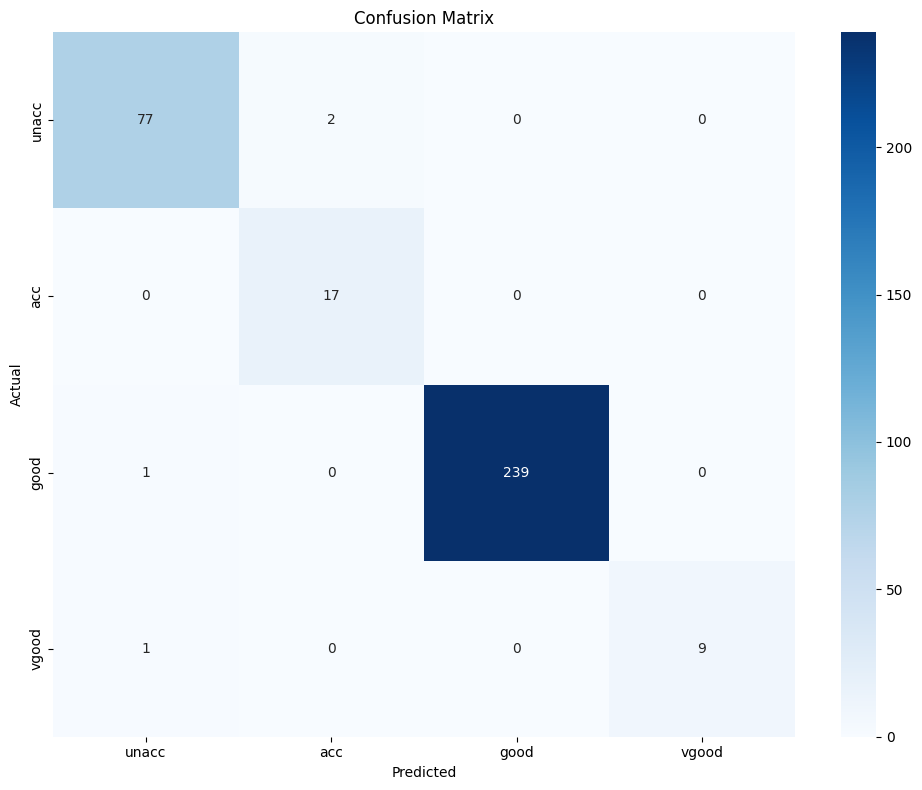

In [17]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create confusion matrix with percentages
cm = confusion_matrix(y_test_original, best_predictions_original)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['unacc', 'acc', 'good', 'vgood'],
            yticklabels=['unacc', 'acc', 'good', 'vgood'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [18]:
# Define ordinal encodings for features and target
feature_ordering = {
    'buying': ['low', 'med', 'high', 'vhigh'],
    'maint': ['low', 'med', 'high', 'vhigh'],
    'doors': ['2', '3', '4', '5more'],
    'persons': ['2', '4', 'more'],
    'lug_boot': ['small', 'med', 'big'],
    'safety': ['low', 'med', 'high']
}

# Create ordinal encoder for features
ord_enc_X = OrdinalEncoder(categories=[feature_ordering[col] for col in X.columns])
X_encoded = ord_enc_X.fit_transform(X)

# Create ordinal encoder for target with consistent class labels
ord_enc_y = OrdinalEncoder(categories=[['unacc', 'acc', 'good', 'vgood']])
y_encoded = ord_enc_y.fit_transform(y.values.reshape(-1, 1))

# Convert back to dataframe/series
X_encoded = pd.DataFrame(X_encoded, columns=X.columns)
y_encoded = pd.Series(y_encoded.ravel())

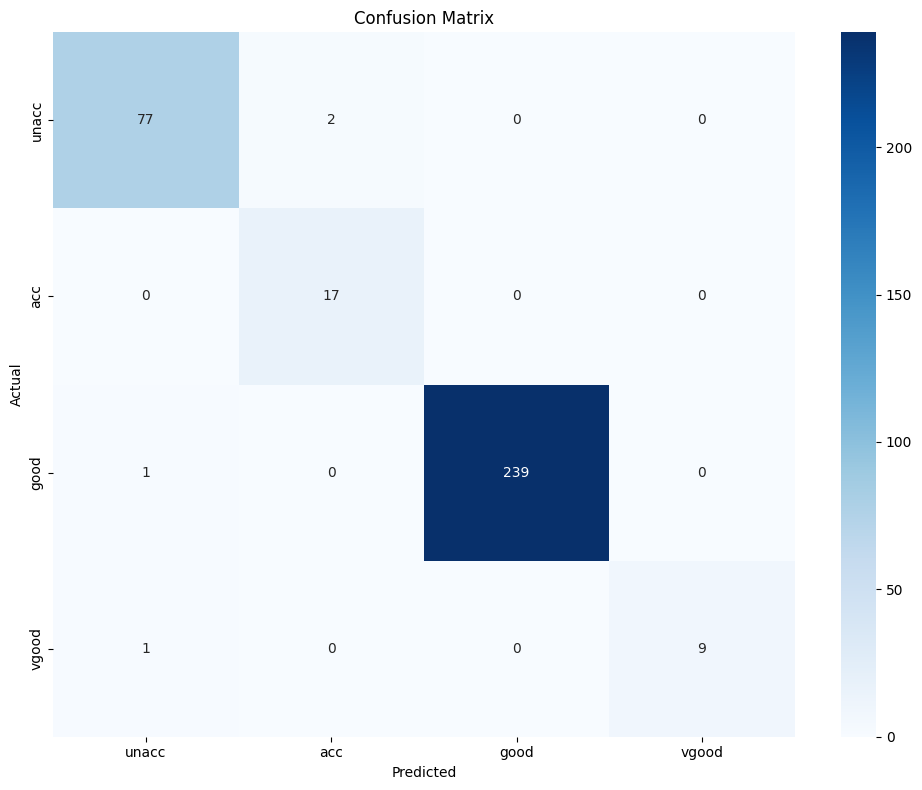

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['unacc', 'acc', 'good', 'vgood'],
            yticklabels=['unacc', 'acc', 'good', 'vgood'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()